In [35]:
from pathlib import Path

import geopandas as gpd
import fiona
import numpy as np
import pandas as pd

from climada.util.api_client import Client
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.entity import Exposures


notebook_dir = %pwd

# Go up one directory
BASE_DIR = Path(notebook_dir).parent

# Define the paths for exposures and hazards
DATA_DIR = BASE_DIR / "data"
EXPOSURES_DIR = BASE_DIR / "data" / "exposures"
HAZARDS_DIR = BASE_DIR / "data" / "hazards"


client = Client()

In [ ]:
data_type_infos= client.list_data_type_infos()
data_type_infos

In [ ]:
data_type_groups = set([data_type_info.data_type_group for data_type_info in data_type_infos])
data_type_groups

In [ ]:
data_type_exposures = [data_type_info for data_type_info in data_type_infos if data_type_info.data_type_group == 'exposures']
data_type_exposures

In [ ]:
data_type_hazards = [data_type_info for data_type_info in data_type_infos if data_type_info.data_type_group == 'hazard']
data_type_hazards

In [ ]:
dataset_infos = client.list_dataset_infos(
    properties={
        'country_name': ['Egypt'],
        # 'country_name': ['Egypt', 'Thailand'],
    }
)
dataset_infos

In [ ]:
data_types_set = list(set([dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'hazard']))
data_types_set

In [ ]:
egypt_litpop_dataset_info = client.get_dataset_info(
    data_type='litpop', 
    properties={
        'country_name': 'Egypt',
        'exponents': '(1,1)'
    }
)
egypt_litpop_dataset_info

In [ ]:
thailand_litpop_dataset_info = client.get_dataset_info(
    data_type='litpop', 
    properties={
        'country_name': 'Egypt',
        'exponents': '(1,1)'
    }
)
thailand_litpop_dataset_info

In [ ]:
dataset_infos = client.list_dataset_infos(
    properties={
        'data_type':'tropical_cyclone',
        'country_name': ['Egypt'],
        'climate_scenario': 'None'
    }
)
dataset_infos

In [ ]:
dataset_infos = client.list_dataset_infos(
    properties={
        'data_type':'river_flood',
        'country_name': ['Egypt'],
        'climate_scenario': 'historical'
    }
)
dataset_infos

In [2]:
exposure = client.get_litpop(
    country='Egypt',
    exponents=(1,1),
    dump_dir=EXPOSURES_DIR
)

In [ ]:
exposure.gdf

In [ ]:
exposure.plot_raster()

In [ ]:
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

haz_ras = Hazard.from_raster([HAZ_DEMO_FL], haz_type='FL', dst_crs=exposure.meta['crs'], transform=exposure.meta['transform'],
                             width=exposure.meta['width'], height=exposure.meta['height'],
                             resampling=Resampling.nearest)
haz_ras.intensity[haz_ras.intensity==-9999] = 0 # correct no data values
haz_ras.plot_intensity(0)

In [ ]:
import rasterio
import numpy as np
import pandas as pd

with rasterio.open('SC22000_VE__M1.grd') as src:
    array = src.read(1)

# Replace 'nodata' values with NaN if needed
array[array == src.nodata] = np.nan

# Convert to DataFrame
df = pd.DataFrame(array)
df

In [3]:
hazard = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'country_name': 'Egypt',
        'climate_scenario': 'historical'
    },
    dump_dir=HAZARDS_DIR,
)

In [13]:
hazard.intensity_thres = 1
impact_function = ImpactFunc()
impact_function.haz_type = "RF"
impact_function.intensity_unit = "m"
impact_function.id = 3
impact_function.name = "Flood Europe JRC Residential"
impact_function.intensity = np.array(
    [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 12.0]
)
impact_function.mdd = np.array(
    [0.00, 0.25, 0.40, 0.50, 0.60, 0.75, 0.85, 0.95, 1.00, 1.00]
)
impact_function.mdr = np.array(
    [0.000, 0.250, 0.400, 0.500, 0.600, 0.750, 0.850, 0.950, 1.000, 1.000]
)
impact_function.paa = np.ones(len(impact_function.intensity))
impact_function_set = ImpactFuncSet()
impf_id = 3

impact_function_set.append(impact_function)
exposure.gdf[f"impf_{impact_function.haz_type}"] = impf_id

impact = Impact()
impact.calc(exposure, impact_function_set, hazard, save_mat=True)

impact


2023-11-15 20:45:02,784 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


(array([[<GeoAxesSubplot:title={'center':'Return period: 25 years'}>,
         <GeoAxesSubplot:title={'center':'Return period: 50 years'}>],
        [<GeoAxesSubplot:title={'center':'Return period: 100 years'}>,
         <GeoAxesSubplot:title={'center':'Return period: 250 years'}>]],
       dtype=object),
 array([[3.51107827e-05, 6.31844924e-06, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.63944813e-05, 8.34903561e-06, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.76781799e-05, 1.03796220e-05, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.25944180e-05, 1.30639111e-05, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))

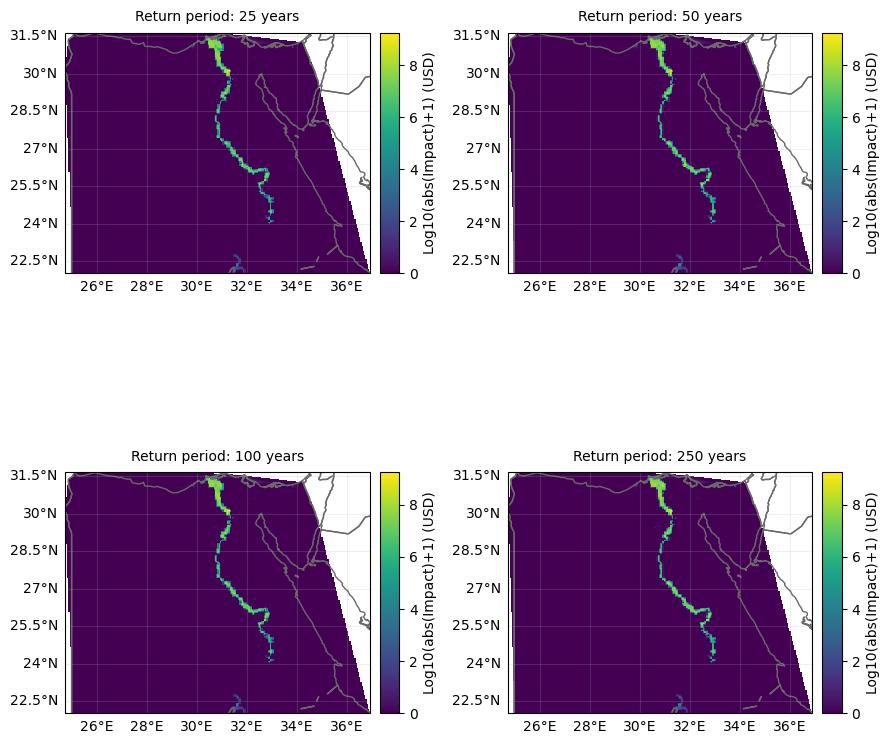

In [22]:
impact.plot_rp_imp()

In [47]:
filepath = DATA_DIR / "dev" / "gadm41_EGY.gpkg"
adm_gdf = gdf = gpd.read_file(filepath, layer=1) # access layers by index (ex: 1) or name (ex: 'ADM_ADM_0')
adm_gdf.head()

GID_1 GID_0 COUNTRY            NAME_1                         VARNAME_1  \
0  EGY.1_1   EGY   Egypt     Ad Daqahliyah  Al Daqahliyah|Dacahlia|Dagahlia|   
1  EGY.2_1   EGY   Egypt  Al Bahr al Ahmar  Mar Rojo|Mar Vermelho|Mer Rouge|   
2  EGY.3_1   EGY   Egypt       Al Buhayrah  Beheira|Behera|El Buhayra|Béhéra   
3  EGY.4_1   EGY   Egypt         Al Fayyum  El Faiyum|el Fayoum|Faium|Faiyūm   
4  EGY.5_1   EGY   Egypt      Al Gharbiyah  al-Garbīyah|El Gharbiya|Garbia|G   

             NL_NAME_1     TYPE_1    ENGTYPE_1 CC_1 HASC_1   ISO_1  \
0             الدقهلية  Muhafazah  Governorate   NA  EG.DQ   EG-DK   
1  محافظة البحر الأحمر  Muhafazah  Governorate   NA  EG.BA   EG-BA   
2              البحيرة  Muhafazah  Governorate   NA  EG.BH   EG-BH   
3        محافظة الفيوم  Muhafazah  Governorate   NA  EG.FY  EG-FYM   
4       محافظة الغربية  Muhafazah  Governorate   NA  EG.GH   EG-GH   

                                            geometry  
0  MULTIPOLYGON (((31.37191 30.75982, 31.36459 30...  
1  MULTIPOLYGON (((35.47458 24.14069, 35.47458 24...  
2  MULTIPOLYGON (((30.52893 30.47858, 30.48588 30...  
3  MULTIPOLYGON (((30.94840 29.20572, 30.94753 29...  
4  MULTIPOLYGON (((31.23971 31.05595, 31.25710 31...

In [16]:
# List all layers in the GeoPackage
layer_names = gpd.io.file.fiona.listlayers(filepath)
for name in layer_names:
    print(name)


ADM_ADM_0
ADM_ADM_1
ADM_ADM_2


In [72]:
exp_gdf = exposure.gdf
exp_gdf

value                   geometry   latitude  longitude  \
0       5818.850950  POINT (35.60417 23.10417)  23.104167  35.604167   
1       2754.686960  POINT (35.56250 23.06250)  23.062500  35.562500   
2       2981.679567  POINT (35.60417 23.06250)  23.062500  35.604167   
3        686.425475  POINT (35.64583 23.06250)  23.062500  35.645833   
4        611.069759  POINT (35.52083 23.02083)  23.020833  35.520833   
...             ...                        ...        ...        ...   
52118   9120.352229  POINT (34.52083 27.93750)  27.937500  34.520833   
52119  15787.142583  POINT (34.56250 27.93750)  27.937500  34.562500   
52120   8923.414753  POINT (34.60417 27.93750)  27.937500  34.604167   
52121   1943.688900  POINT (33.10417 31.22917)  31.229167  33.104167   
52122   1045.704309  POINT (33.18750 31.22917)  31.229167  33.187500   

       region_id  impf_  
0            818      1  
1            818      1  
2            818      1  
3            818      1  
4            818      1  
...          ...    ...  
52118        818      1  
52119        818      1  
52120        818      1  
52121        818      1  
52122        818      1  

[52123 rows x 6 columns]

In [84]:
filepath = DATA_DIR / "dev" / "gadm41_EGY.gpkg"
layer = 1
exposure_filepath = EXPOSURES_DIR / "LitPop_150arcsec_EGY.hdf5"
exposure = Exposures().from_hdf5(exposure_filepath)
exp_gdf = exposure.gdf
adm_gdf = gpd.read_file(filepath, layer=layer) # access layers by index (ex: 1) or name (ex: 'ADM_ADM_0')

joined_gdf = gpd.sjoin(exp_gdf, adm_gdf, how="left", predicate='within')
aggregated_values = joined_gdf.groupby(f'GID_{layer}')['value'].sum().reset_index()
adm_gdf = adm_gdf.merge(aggregated_values, on=f'GID_{layer}', how='left')
adm_gdf['value'] = adm_gdf['value'].fillna(0)
adm_gdf

resp_gdf = adm_gdf[['NAME_1', 'geometry', 'value']]
resp_gdf


NAME_1                                           geometry  \
0      Ad Daqahliyah  MULTIPOLYGON (((31.37191 30.75982, 31.36459 30...   
1   Al Bahr al Ahmar  MULTIPOLYGON (((35.47458 24.14069, 35.47458 24...   
2        Al Buhayrah  MULTIPOLYGON (((30.52893 30.47858, 30.48588 30...   
3          Al Fayyum  MULTIPOLYGON (((30.94840 29.20572, 30.94753 29...   
4       Al Gharbiyah  MULTIPOLYGON (((31.23971 31.05595, 31.25710 31...   
5    Al Iskandariyah  MULTIPOLYGON (((29.63280 30.26276, 29.63277 30...   
6     Al Isma`iliyah  MULTIPOLYGON (((31.79850 30.48218, 31.82200 30...   
7           Al Jizah  MULTIPOLYGON (((30.64093 30.17111, 30.64258 30...   
8       Al Minufiyah  MULTIPOLYGON (((31.04201 30.20961, 31.03384 30...   
9           Al Minya  MULTIPOLYGON (((30.85316 27.60245, 30.84006 27...   
10        Al Qahirah  MULTIPOLYGON (((31.29614 29.80414, 31.29582 29...   
11     Al Qalyubiyah  MULTIPOLYGON (((31.26192 30.10975, 31.25611 30...   
12          Al Uqsur  MULTIPOLYGON (((32.83179 25.69325, 32.83172 25...   
13  Al Wadi al Jadid  MULTIPOLYGON (((31.00323 22.00781, 30.97752 22...   
14         As Suways  MULTIPOLYGON (((32.15926 28.99878, 31.96388 28...   
15     Ash Sharqiyah  MULTIPOLYGON (((31.59172 30.19752, 31.55611 30...   
16             Aswan  MULTIPOLYGON (((33.49407 21.77337, 33.48934 21...   
17             Asyut  MULTIPOLYGON (((30.71217 27.61026, 30.71061 27...   
18       Bani Suwayf  MULTIPOLYGON (((31.78501 28.74219, 31.76611 28...   
19         Bur Sa`id  MULTIPOLYGON (((32.18477 31.03757, 32.17678 31...   
20            Dumyat  MULTIPOLYGON (((31.62034 31.23109, 31.61932 31...   
21       Janub Sina'  MULTIPOLYGON (((33.21653 28.79125, 33.21625 28...   
22   Kafr ash Shaykh  MULTIPOLYGON (((30.52413 31.19709, 30.52599 31...   
23           Matrouh  MULTIPOLYGON (((25.00000 27.66560, 25.00000 27...   
24              Qina  MULTIPOLYGON (((32.47102 25.34958, 32.46049 25...   
25      Shamal Sina'  MULTIPOLYGON (((32.93270 30.23623, 32.91904 30...   
26             Suhaj  MULTIPOLYGON (((31.44809 26.63269, 31.32301 26...   

           value  
0   1.997026e+10  
1   2.368958e+08  
2   1.963108e+10  
3   1.139028e+10  
4   1.813604e+10  
5   1.560249e+10  
6   2.954739e+09  
7   4.155533e+10  
8   1.734039e+10  
9   1.616397e+10  
10  3.791384e+10  
11  2.523439e+10  
12  1.125315e+10  
13  1.831884e+08  
14  6.756141e+08  
15  2.521297e+10  
16  9.375590e+08  
17  1.531681e+10  
18  1.009482e+10  
19  6.362816e+08  
20  4.142057e+09  
21  2.880840e+07  
22  8.267442e+09  
23  1.573417e+08  
24  9.463824e+09  
25  2.141751e+08  
26  1.730352e+10

In [88]:
str(filepath)

'c:\\Users\\gkalomalos\\Projects\\unu\\climada-unu\\data\\dev\\gadm41_EGY.gpkg'

In [87]:
resp_data = resp_gdf.to_json()
print(resp_data)

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"NAME_1": "Ad Daqahliyah", "value": 19970264674.659424}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[31.371910094999976, 30.75981521500006], [31.36458969100005, 30.747024536000026], [31.373937607000073, 30.74583435000011], [31.369148255000084, 30.73738479700006], [31.38293647800009, 30.714672090000136], [31.37350845400016, 30.710206986000173], [31.383054734000098, 30.704244614000118], [31.38316535900009, 30.684417725000174], [31.390333175000023, 30.672082901000124], [31.37231254600016, 30.663711549000084], [31.387453080000057, 30.62296486000014], [31.345071792000113, 30.6214885710001], [31.341728210000042, 30.608045578000088], [31.329917907000095, 30.61092186000019], [31.32056999100007, 30.59432411300014], [31.296564101000172, 30.587593080000147], [31.283813476000034, 30.590860368000165], [31.282300948000113, 30.607067108000138], [31.268356322000102, 30.601730347000057], [31.26422500600